In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation

In [2]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import shutil

In [3]:
def data_augmentation(input_dir, output_dir):
    # List all classes (assuming each subdirectory represents a class)
    classes = os.listdir(input_dir)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        # Clear existing files in the directory
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    # Dictionary to store file paths for each class
    data = {cls: [] for cls in classes}

    # Gather file paths for each class
    for cls in classes:
        cls_dir = os.path.join(input_dir, cls)
        data[cls] = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)]

    # ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generate and save augmented images
    for cls, files in data.items():
        cls_augmented_dir = os.path.join(output_dir, cls)
        os.makedirs(cls_augmented_dir)

        for file in files:
            img = load_img(file)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=cls_augmented_dir, save_prefix=cls, save_format='jpg'):
                i += 1
                if i >= 5:  # Generate 5 augmented images for each original image
                    break

In [4]:
# Usage example:
input_directory = "D:/Drone/New folder (2)/asl_alphabet_train"
output_directory = "D:/Drone/New folder (2)/asl_alphabet_train_augmented"

data_augmentation(input_directory, output_directory)

# Load and preprocess the dataset

In [2]:
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# Define the path to the dataset
data_dir = "D:/Drone/CODE/New folder (2)/data"

# List all classes (assuming each subdirectory represents a class)
classes = os.listdir(data_dir)

# Dictionary to store file paths for each class
data = {cls: [] for cls in classes}

In [3]:
# Gather file paths for each class
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    data[cls] = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)]

# Split data into train, test, and validation sets

In [4]:
# Split data into train, test, and validation sets
train_data = {}
test_data = {}
val_data = {}
for cls, files in data.items():
    train, test = train_test_split(files, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 (20% validation)
    train_data[cls] = train
    test_data[cls] = test
    val_data[cls] = val

In [5]:
# Create DataFrames for train, test, and validation sets
train_df = pd.DataFrame([(file, cls) for cls, files in train_data.items() for file in files], columns=['file', 'class'])
test_df = pd.DataFrame([(file, cls) for cls, files in test_data.items() for file in files], columns=['file', 'class'])
val_df = pd.DataFrame([(file, cls) for cls, files in val_data.items() for file in files], columns=['file', 'class'])

# ImageDataGenerator

In [6]:
# ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [7]:
# Flow from dataframe for train, test, and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5220 validated image filenames belonging to 5 classes.
Found 1743 validated image filenames belonging to 5 classes.
Found 1742 validated image filenames belonging to 5 classes.


# Build The CNN Model

In [11]:
# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))  # 5 classes for the gestures

In [12]:
from keras.optimizers import Adam
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # adjust as needed
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10
164/164 [==============================] - 197s 1s/step - loss: 0.7727 - accuracy: 0.6762 - val_loss: 0.3607 - val_accuracy: 0.8186
Epoch 2/10
164/164 [==============================] - 181s 1s/step - loss: 0.3505 - accuracy: 0.8577 - val_loss: 0.2847 - val_accuracy: 0.8685
Epoch 3/10
164/164 [==============================] - 180s 1s/step - loss: 0.2759 - accuracy: 0.8906 - val_loss: 0.1424 - val_accuracy: 0.9483
Epoch 4/10
164/164 [==============================] - 175s 1s/step - loss: 0.1953 - accuracy: 0.9284 - val_loss: 0.1283 - val_accuracy: 0.9564
Epoch 5/10
164/164 [==============================] - 171s 1s/step - loss: 0.1424 - accuracy: 0.9479 - val_loss: 0.0811 - val_accuracy: 0.9736
Epoch 6/10
164/164 [==============================] - 168s 1s/step - loss: 0.1429 - accuracy: 0.9538 - val_loss: 0.0988 - val_accuracy: 0.9673
Epoch 7/10
164/164 [==============================] - 168s 1s/step - loss: 0.1111 - accuracy: 0.9605 - val_loss: 0.0572 - val_accuracy: 0.9845

# Loss

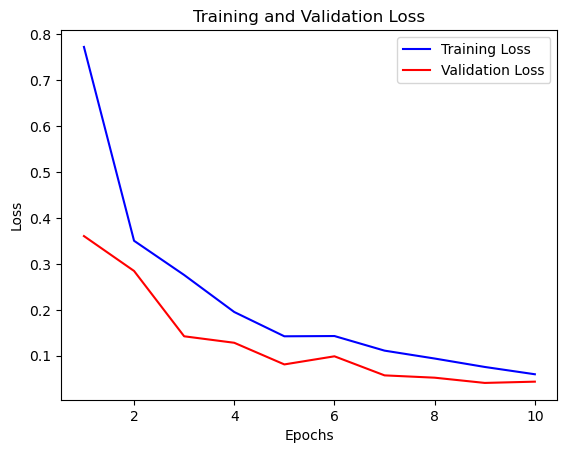

In [14]:
import matplotlib.pyplot as plt

# Accessing training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy

In [15]:
# Evaluate the model on test data
accuracy = model.evaluate(test_generator, steps=len(test_generator))[1]
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

55/55 [==============================] - 24s 446ms/step - loss: 0.0565 - accuracy: 0.9822
Accuracy on test data: 98.22%


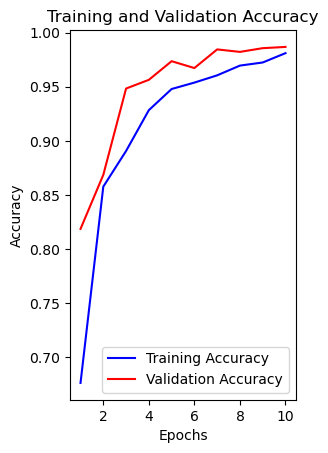

In [16]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Other Measurments

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Predict probabilities for test set
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = test_generator.classes

55/55 [==============================] - 18s 315ms/step


# Confusion Matrix

In [18]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 63  79  88  64  57]
 [ 84 100  69  91  60]
 [ 76  74  59  62  64]
 [ 57  80  58  54  80]
 [ 73  69  63  53  66]]


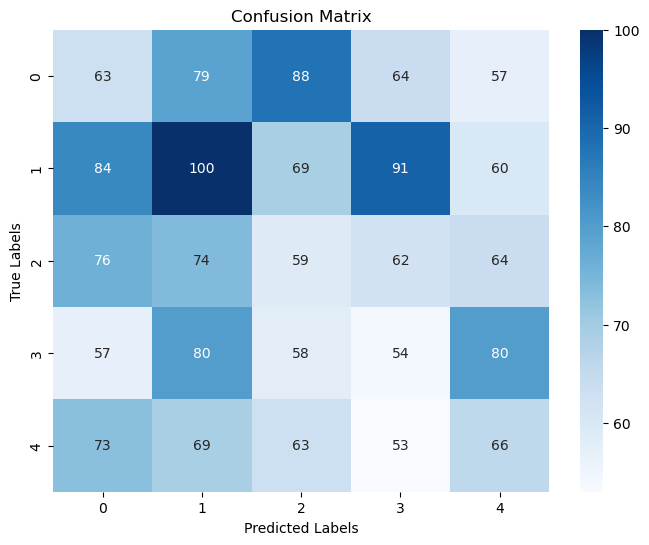

In [19]:
import numpy as np
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report

In [20]:
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.18      0.18       351
           1       0.25      0.25      0.25       404
           2       0.18      0.18      0.18       335
           3       0.17      0.16      0.17       329
           4       0.20      0.20      0.20       324

    accuracy                           0.20      1743
   macro avg       0.19      0.19      0.19      1743
weighted avg       0.20      0.20      0.20      1743



# Save The Model

In [21]:
# Assuming you've trained and have a model object named 'model'
model.save('CNN02_model01.h5')

C:\Users\ADMIN\Conda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Rewrite the model as it overfit

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the CNN model with dropout and regularization
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

# Using callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [26]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [27]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
164/164 [==============================] - 186s 1s/step - loss: 1.0057 - accuracy: 0.5644 - val_loss: 0.5819 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 2/10
164/164 [==============================] - 185s 1s/step - loss: 0.4372 - accuracy: 0.8136 - val_loss: 0.3082 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 3/10
164/164 [==============================] - 183s 1s/step - loss: 0.3333 - accuracy: 0.8741 - val_loss: 0.1815 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 4/10
164/164 [==============================] - 186s 1s/step - loss: 0.2608 - accuracy: 0.9046 - val_loss: 0.1241 - val_accuracy: 0.9621 - lr: 0.0010
Epoch 5/10
164/164 [==============================] - 184s 1s/step - loss: 0.1664 - accuracy: 0.9444 - val_loss: 0.0809 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 6/10
164/164 [==============================] - 184s 1s/step - loss: 0.1488 - accuracy: 0.9471 - val_loss: 0.0819 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 7/10
164/164 [==============================] - 183s 1s/st

# Loss

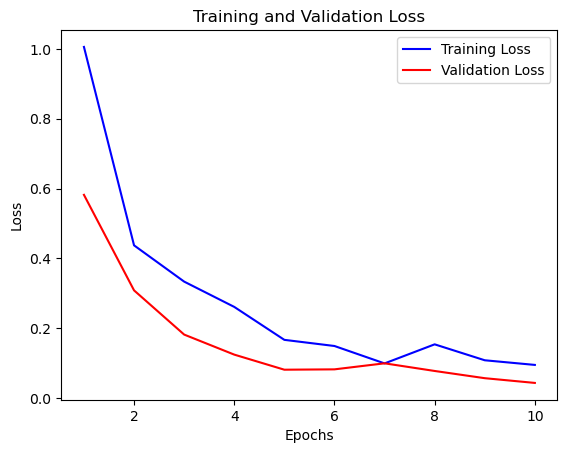

In [28]:
import matplotlib.pyplot as plt

# Accessing training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy

In [29]:
# Evaluate the model on test data
accuracy = model.evaluate(test_generator, steps=len(test_generator))[1]
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

55/55 [==============================] - 24s 441ms/step - loss: 0.0439 - accuracy: 0.9845
Accuracy on test data: 98.45%


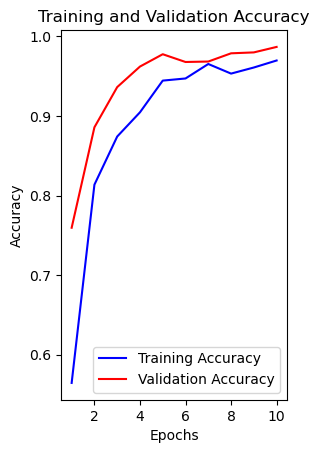

In [30]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Predict probabilities for test set
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = test_generator.classes

55/55 [==============================] - 17s 314ms/step


# Confusion Matrix

In [32]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[71 86 76 66 52]
 [77 95 68 78 86]
 [71 76 56 62 70]
 [73 78 59 57 62]
 [61 78 65 64 56]]


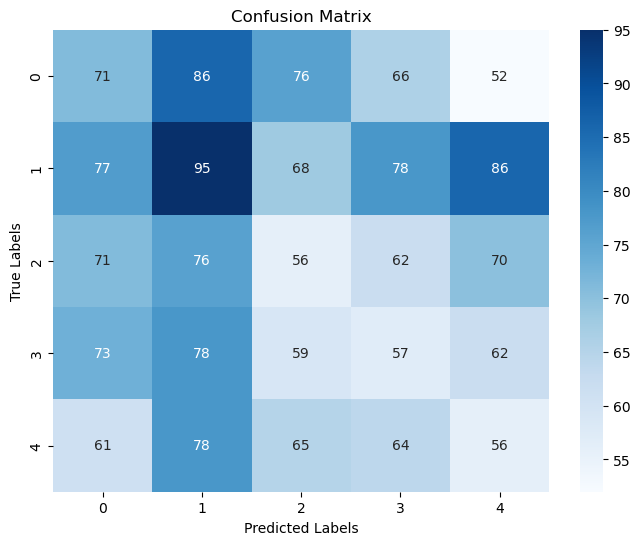

In [33]:
import numpy as np
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report

In [34]:
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)



Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.20      0.20       351
           1       0.23      0.24      0.23       404
           2       0.17      0.17      0.17       335
           3       0.17      0.17      0.17       329
           4       0.17      0.17      0.17       324

    accuracy                           0.19      1743
   macro avg       0.19      0.19      0.19      1743
weighted avg       0.19      0.19      0.19      1743



# Save The Model

In [35]:
model.save('CNN02_model02.h5')

C:\Users\ADMIN\Conda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Use ResNet 

In [8]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Create the base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the ResNet50 base model
model = Sequential()
model.add(base_model)

# Add additional layers on top of the ResNet50 base model
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # adjust as needed
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10
164/164 [==============================] - 265s 2s/step - loss: 0.9744 - accuracy: 0.5807 - val_loss: 0.5458 - val_accuracy: 0.7985
Epoch 2/10
164/164 [==============================] - 258s 2s/step - loss: 0.5931 - accuracy: 0.7625 - val_loss: 0.4213 - val_accuracy: 0.8617
Epoch 3/10
164/164 [==============================] - 264s 2s/step - loss: 0.4531 - accuracy: 0.8310 - val_loss: 0.3257 - val_accuracy: 0.8789
Epoch 4/10
164/164 [==============================] - 257s 2s/step - loss: 0.4396 - accuracy: 0.8324 - val_loss: 0.2812 - val_accuracy: 0.9013
Epoch 5/10
164/164 [==============================] - 268s 2s/step - loss: 0.3785 - accuracy: 0.8584 - val_loss: 0.2438 - val_accuracy: 0.9133
Epoch 6/10
164/164 [==============================] - 254s 2s/step - loss: 0.3556 - accuracy: 0.8688 - val_loss: 0.2259 - val_accuracy: 0.9179
Epoch 7/10
164/164 [==============================] - 256s 2s/step - loss: 0.3750 - accuracy: 0.8603 - val_loss: 0.1992 - val_accuracy: 0.9237

# Loss

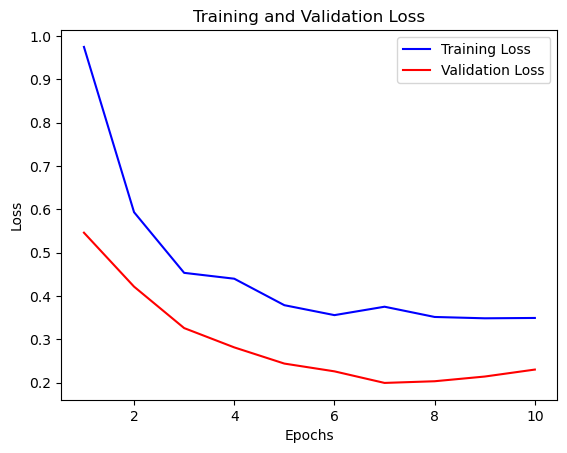

In [10]:
import matplotlib.pyplot as plt

# Accessing training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy

In [11]:
# Evaluate the model on test data
accuracy = model.evaluate(test_generator, steps=len(test_generator))[1]
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

55/55 [==============================] - 67s 1s/step - loss: 0.2320 - accuracy: 0.9203
Accuracy on test data: 92.03%


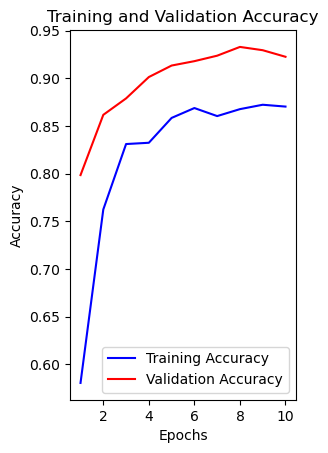

In [12]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Predict probabilities for test set
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = test_generator.classes

55/55 [==============================] - 62s 1s/step


# Confusion Matrix

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[80 76 66 54 75]
 [70 89 84 67 94]
 [65 80 67 61 62]
 [59 74 66 46 84]
 [68 77 47 63 69]]


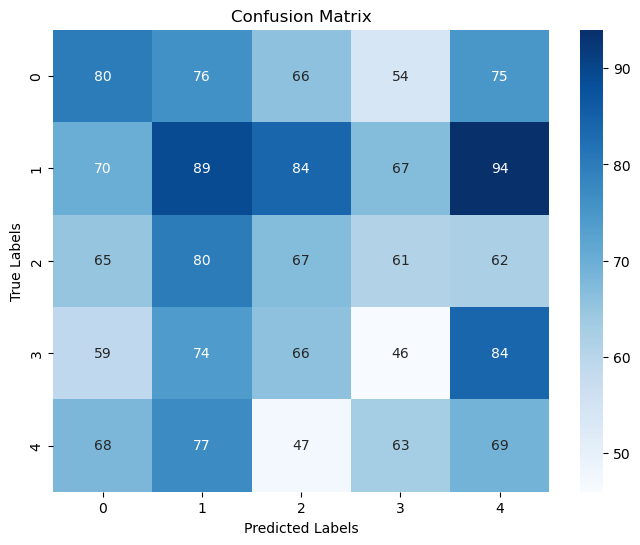

In [15]:
import numpy as np
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report

In [16]:
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.23      0.23       351
           1       0.22      0.22      0.22       404
           2       0.20      0.20      0.20       335
           3       0.16      0.14      0.15       329
           4       0.18      0.21      0.19       324

    accuracy                           0.20      1743
   macro avg       0.20      0.20      0.20      1743
weighted avg       0.20      0.20      0.20      1743



# Save the Model 

In [17]:
model.save('CNN02_model03.h5')

C:\Users\ADMIN\Conda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
